<a href="https://colab.research.google.com/github/namwootree/Portfolio/blob/main/Alphaco_(Deep_Learning_Boot_Camp)/Long-Term%20Program/Text_Summarization/Reference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dacon Gas**

## **Abstract**

본 문서는 한국가스공사에서 주최 및 주관하고, 데이콘 주식회사에서 운영한 가스・에너지분야 문서요약 모델개발 대회에 참여한 이야기연구소 주식회사의 모델 복원을 위한 코드입니다. PyTorch를 백엔드로 하는 HuggingFace Trainer와 Pretrain된 KoBART를 Finetuning 하였으며, 특별히 [기존 코드](https://github.com/cawandmilk/gas)에서 변경된 사항은 아래와 같습니다.

* 자체 서버와는 달리 코랩 환경에서는 리소스 사용량에 제한이 있으므로, 훈련 및 추론 시간을 줄이기 위해 전체 데이터의 10%만 덜어서 사용하였습니다.

* 비공개 테스트 데이터 세트는 대회 종료 이후 공개되지 않을 예정이므로, 검증용 데이터 세트의 일부를 덜어내어 실제 추론간 사용하였습니다.

* 비공개 테스트 데이터 세트의 정답을 알고있으며 [채점 프로그램](https://dacon.io/competitions/official/235673/talkboard/401911?page=1&dtype=recent) 또한 공개되어 있으므로, 생성문에 대한 Rouge Score를 계산하는 코드를 추가하였습니다.

## **Default Setting**

In [ ]:
!sudo apt-get install tree

In [ ]:
!pip install -q transformers

In [ ]:
import torch
import transformers

import datetime
import easydict
import itertools
import json
import matplotlib
import pathlib
import pprint
import re

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from operator import itemgetter
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from typing import List, Dict

## Version.
print("[VERSION]")
print(f"torch: {torch.__version__}")
print(f"transformers: {transformers.__version__}")

[VERSION]
torch: 1.10.0+cu111
transformers: 4.15.0


In [ ]:
!python -V

Python 3.7.12


In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         167G   43G  125G  26% /
tmpfs            64M     0   64M   0% /dev
shm              13G     0   13G   0% /dev/shm
/dev/root       2.0G  1.2G  817M  59% /sbin/docker-init
tmpfs            13G   28K   13G   1% /var/colab
/dev/sda1       174G   46G  128G  27% /opt/bin/.nvidia
tmpfs            13G     0   13G   0% /proc/acpi
tmpfs            13G     0   13G   0% /proc/scsi
tmpfs            13G     0   13G   0% /sys/firmware


In [ ]:
!nvidia-smi; free -h

Mon Dec 27 04:18:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def print_elements(a: dict) -> None:
    pprint.PrettyPrinter(indent=4).pprint(a)

config = easydict.EasyDict({
    "raw_train_path": "./data/Training",
    "raw_valid_path": "./data/Validation",
    "clean": False,
    "data": "data", ## data path
    "seed": 42,
    "sample_submission_path": "sample_submission.tsv",
    "answer_path": "answer.tsv",
    "prediction_path": "prediction.tsv",
    "pretrained_model_name": "gogamza/kobart-base-v1",
    "train": "data/train.tsv",
    "valid": "data/valid.tsv",
    "test": "data/test.tsv",
    ## Training arguments.
    "ckpt": "ckpt", ## path
    "logs": "logs", ## path
    "per_replica_batch_size": 8,
    "gradient_accumulation_steps": 16,
    "lr": 5e-5,
    "weight_decay": 1e-2,
    "warmup_ratio": 0.2,
    "n_epochs": 10,
    "inp_max_len": 1024,
    "tar_max_len": 256,
    "model_fpath": "/content/drive/MyDrive/ColabNotebooks/dacon-gas/kobart-model.pth",
    ## Inference.
    "gpu_id": 0,
    "beam_size": 5,
    "length_penalty": 0.8,
    "no_repeat_ngram_size": 3,
    "var_len": False,
})

print_elements(vars(config)) ## sort_dicts=False -> > python 3.8

{   'answer_path': 'answer.tsv',
    'beam_size': 5,
    'ckpt': 'ckpt',
    'clean': False,
    'data': 'data',
    'gpu_id': 0,
    'gradient_accumulation_steps': 16,
    'inp_max_len': 1024,
    'length_penalty': 0.8,
    'logs': 'logs',
    'lr': 5e-05,
    'model_fpath': '/content/drive/MyDrive/ColabNotebooks/dacon-gas/kobart-model.pth',
    'n_epochs': 10,
    'no_repeat_ngram_size': 3,
    'per_replica_batch_size': 8,
    'prediction_path': 'prediction.tsv',
    'pretrained_model_name': 'gogamza/kobart-base-v1',
    'raw_train_path': './data/Training',
    'raw_valid_path': './data/Validation',
    'sample_submission_path': 'sample_submission.tsv',
    'seed': 42,
    'tar_max_len': 256,
    'test': 'data/test.tsv',
    'train': 'data/train.tsv',
    'valid': 'data/valid.tsv',
    'var_len': False,
    'warmup_ratio': 0.2,
    'weight_decay': 0.01}


In [ ]:
try:
    from google.colab import drive
    drive.mount("/content/drive")
except:
    raise AssertionError()

Mounted at /content/drive


## **Get Dataset**

[AI Hub](https://aihub.or.kr/aidata/8054)에서 다운로드 받은 데이터 세트를 그대로 압축하여 구글 드라이브에 올리고, 이를 Colab에서 마운트하여 사용하였습니다. Google Drive에 위치한 파일의 저장 경로만 적절히 수정 후 실행하시면 됩니다.

실행 결과는 다음과 같아야 합니다.

```bash
./data
├── [4.0K]  Training
│   ├── [ 75M]  사설_train_original.zip
│   ├── [ 16M]  법률_train_original.zip
│   └── [267M]  신문기사_train_original.zip
└── [4.0K]  Validation
    ├── [1.6M]  법률_valid_original.zip
    ├── [7.9M]  사설_valid_original.zip
    └── [ 34M]  신문기사_valid_original.zip

2 directories, 6 files
```

In [ ]:
%%bash
## Copy zip file from google drive to colab session.
cp "/content/drive/MyDrive/ColabNotebooks/dacon-gas/data/문서요약 텍스트.zip" ./

## Unzip.
mkdir ./data
unzip -q "/content/문서요약 텍스트.zip" -d ./data

## Show lists.
tree -alh ./data

./data
├── [4.0K]  Training
│   ├── [ 75M]  사설_train_original.zip
│   ├── [ 16M]  법률_train_original.zip
│   └── [267M]  신문기사_train_original.zip
└── [4.0K]  Validation
    ├── [1.6M]  법률_valid_original.zip
    ├── [7.9M]  사설_valid_original.zip
    └── [ 34M]  신문기사_valid_original.zip

2 directories, 6 files


필요한 신문기사 데이터 세트만 압축을 해제하여 사용합니다.

마찬가지로, 실행 결과는 다음과 같아야 합니다.

```bash
./data
├── [4.0K]  Training
│   ├── [1.1G]  신문기사_train_original.json
│   ├── [ 75M]  사설_train_original.zip
│   ├── [ 16M]  법률_train_original.zip
│   └── [267M]  신문기사_train_original.zip
└── [4.0K]  Validation
    ├── [140M]  신문기사_valid_original.json
    ├── [1.6M]  법률_valid_original.zip
    ├── [7.9M]  사설_valid_original.zip
    └── [ 34M]  신문기사_valid_original.zip

2 directories, 8 files
```

In [ ]:
%%bash
## Extract only "신문기사" dataset.
cd /content/data/Training \
    && unzip -q "신문기사_train_original.zip" \
    && mv ./train_original.json ./신문기사_train_original.json

cd /content/data/Validation \
    && unzip -q "신문기사_valid_original.zip" \
    && mv ./valid_original.json ./신문기사_valid_original.json

## Show lists.
cd /content && tree -alh ./data

./data
├── [4.0K]  Training
│   ├── [1.1G]  신문기사_train_original.json
│   ├── [ 75M]  사설_train_original.zip
│   ├── [ 16M]  법률_train_original.zip
│   └── [267M]  신문기사_train_original.zip
└── [4.0K]  Validation
    ├── [140M]  신문기사_valid_original.json
    ├── [1.6M]  법률_valid_original.zip
    ├── [7.9M]  사설_valid_original.zip
    └── [ 34M]  신문기사_valid_original.zip

2 directories, 8 files


## **Preprocess**

### **Load JSON**

JSON 포맷의 데이터 세트를 호출합니다.

In [ ]:
def read_samples(raw_path: str, sort_dicts: bool = True) -> List[Dict[str, str]]:
    
    def _read_json(fpath: pathlib.PosixPath) -> List[Dict[str, str]]:
        with open(fpath, "r", encoding="utf-8") as f:
            document = json.loads(f.read())["documents"]
        return document

    # def _read_jsonl(fpath: pathlib.PosixPath) -> List[Dict[str, str]]:
    #     with open(fpath, "r", encoding="utf-8") as f:
    #         documents = [json.loads(line) for line in f]
    #     return documents

    for sample in Path(raw_path).glob("*.json"):
        ## We only use "신문기사" dataset, not "법률" or "사설".
        if not sample.name.startswith("신문기사"):
            continue

        documents = _read_json(sample)

        ## Sort dictionaries by "id".
        if sort_dicts:
            documents = sorted(
                documents,
                key=itemgetter("id"),
                reverse=False,
            )

    return documents

In [ ]:
%%time
## Read corpus.
tr_corpus = read_samples(config.raw_train_path)
vl_corpus = read_samples(config.raw_valid_path)

## Print samples.
print_elements(tr_corpus[0])

{   'abstractive': [   '당진 지역업체인 중앙개발과 GS건설의 하도급 분쟁이 심화되고 있는 가운데 안전 문제를 비롯하여 '
                       '대기업과 하청업체 간의 하도급 실태가 심각한 사회적 문제로 대두되고 있다.'],
    'annotator_id': 121,
    'category': '사회',
    'char_count': '1786',
    'document_quality_scores': {   'accurate': 2,
                                   'informative': 2,
                                   'readable': 2,
                                   'trustworthy': 1},
    'extractive': [1, 15, 13],
    'id': '250362727',
    'media_name': '당진시대',
    'media_sub_type': '지역지',
    'media_type': 'online',
    'publish_date': '2017-01-06 08:31:00',
    'size': 'large',
    'text': [   [   {   'highlight_indices': '',
                        'index': 0,
                        'sentence': '“GS 공사 참여…12억 원 손해” “하도급 문제 근본적 개선 필요하다”'},
                    {   'highlight_indices': '52,53',
                        'index': 1,
                        'sentence': '당진 지역업체인 중앙개발이 최근 GS건설로부터 4건의 공사를 하도급 받아 '
                                   

### **Extract Lines**

불필요한 메타 데이터를 제거한 뒤, 필수적인 입력문(신문기사), 출력문(요약문) 및 id만 추출합니다. 이 과정에서 민감정보 제거 등 공통으로 적용되는 정제 작업과 키 `media_name` (예를 들어, 충청일보, 이데일리 등)에 종속적인 개별 정제 작업이 구현되어 있지만, 실제 성능(Test Rouge Score)이 개선되지 않아 최종적으로는 사용하지 않았습니다.

결측치 및 이상치 제거도 본 과정에서 함께 진행됩니다.

In [ ]:
class CleanNewspaperArticleBase():

    def __init__(
        self, 
    ):
        super(CleanNewspaperArticleBase, self).__init__()


    @staticmethod
    def remove_reporter_info(article_original: List[str]) -> List[str]:
        email_pattern = re.compile(r"[a-zA-Z0-9+-_.]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$")
        reporter_pattern = re.compile(r"^\/?([가-힣]+)\s?(기자|팀)?\s*\.?$")

        texts = []
        reporters = []
        for sentence in article_original:
            ## If we can find email pattern in one sentence:
            email = email_pattern.findall(sentence)
            if email != []:
                continue
            
            ## We don't care about "OOO 기자 OOO 기자", not "OOO 기자"
            reporter = reporter_pattern.findall(sentence)
            if reporter != []:
                reporters.extend([i[0] for i in reporter])
                continue

            ## If known reporter name is in sentence...
            if any([i in sentence for i in reporters]):
                continue
            
            texts.append(sentence)
        
        return texts


    @staticmethod
    def remove_url(article_original: List[str]) -> List[str]:
        ## (e.g. id="357606465")
        ## Ref: https://www.codegrepper.com/code-examples/python/regex+for+url+python
        url_pattern = re.compile(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", re.MULTILINE)

        texts = "\n".join(article_original)
        texts = url_pattern.sub("", texts)

        return texts.split("\n")


    @staticmethod
    def remove_phone_number(article_original: List[str]) -> List[str]:
        phone_pattern = re.compile(r"""(
            (\d{2}|\(\d{2}\)|\d{3}|\(\d{3}\))?      ## 2 or 3 words include "(...)" patterns -> optional
            (|-|\.)?                                ## sep word: "." or "-"
            (\d{3}|\d{4})                           ## 3 or 4 numbers
            (\s|-|\.)                               ## sep word: "." or "-"
            (\d{4})                                 ## 4 numbers
        )""", re.VERBOSE | re.MULTILINE)  

        texts = "\n".join(article_original)
        texts = phone_pattern.sub("", texts)

        return texts.split("\n")


    @staticmethod
    def remove_brack_sentence(article_original: List[str]) -> List[str]:
        bracket_1_pattern = re.compile(r"\s?<.*>", re.MULTILINE)        ## e.g. "<OOO씨 제공>"
        bracket_2_pattern = re.compile(r"\s?\(.*\)", re.MULTILINE)      ## e.g. 
        bracket_3_pattern = re.compile(r"\s?\[.*\]", re.MULTILINE)      ## e.g. 

        texts = "\n".join(article_original)
        texts = bracket_1_pattern.sub("", texts)
        texts = bracket_2_pattern.sub("", texts)
        texts = bracket_3_pattern.sub("", texts)
        
        return texts.split("\n")


    @staticmethod
    def remove_supplementary_sentence(article_original: List[str]) -> List[str]:
        ## e.g. "/광주시양궁협회 제공"
        ## But, it may be an important sentence... (e.g. id="334957827")
        supplementary_sentence_pattern = re.compile(r"^\s?[▶|\/][.]*", re.MULTILINE)

        texts = "\n".join(article_original)
        texts = supplementary_sentence_pattern.sub("", texts)
        
        return texts.split("\n")


    @staticmethod
    def replace_start_with_hyphen(article_original: List[str]) -> List[str]:
        ## e.g. 
        hyphen_pattern = re.compile(r"^\s?\-", re.MULTILINE)

        texts = "\n".join(article_original)
        texts = hyphen_pattern.sub("", texts)

        return texts.split("\n")

    
    @staticmethod
    def replace_universal_apostrophe(article_original: List[str]) -> List[str]:
        ## “ (U+201C), ” (U+201D) -> " (U+0022)
        ## ‘ (U+2018), ’ (U+2019) -> ' (U+0027)
        small_apostrophe_pattern = re.compile(r"[‘|’]", re.MULTILINE)
        large_apostrophe_pattern = re.compile(r"[“|”]", re.MULTILINE)

        texts = "\n".join(article_original)
        texts = small_apostrophe_pattern.sub("'", texts)
        texts = large_apostrophe_pattern.sub("\"", texts)

        return texts.split("\n")


    @staticmethod
    def replace_repeated_apostrophe(article_original: List[str]) -> List[str]:
        ## (e.g. id="330644133")
        small_apostrophe_pattern = re.compile(r"'{2,}", re.MULTILINE)
        large_apostrophe_pattern = re.compile(r"\"{2,}", re.MULTILINE)

        texts = "\n".join(article_original)
        texts = small_apostrophe_pattern.sub("'", texts)
        texts = large_apostrophe_pattern.sub("\"", texts)

        return texts.split("\n")


    @staticmethod
    def apply(article_original: List[str], minimize: bool = True) -> List[str]:
        texts = article_original
        
        ## Remove functions.
        texts = CleanNewspaperArticleBase.remove_reporter_info(texts)
        texts = CleanNewspaperArticleBase.remove_url(texts)
        texts = CleanNewspaperArticleBase.remove_phone_number(texts)

        if not minimize:
            texts = CleanNewspaperArticleBase.remove_supplementary_sentence(texts)
            texts = CleanNewspaperArticleBase.remove_brack_sentence(texts)

            # Replace functions.
            texts = CleanNewspaperArticleBase.replace_start_with_hyphen(texts)
            texts = CleanNewspaperArticleBase.replace_universal_apostrophe(texts)
            texts = CleanNewspaperArticleBase.replace_repeated_apostrophe(texts)

        return texts


class CleanNewspaperArticle():
    
    def __init__(
        self,
    ):
        super(CleanNewspaperArticle, self).__init__()
        self.media_name_to_function = {
            "건설경제": self._cnews,
            "광양신문": self._gynet,
            "광주매일신문": self._kjdaily,
            "광주일보": self._kwangju,
            "국제신문": self._kookje,
            "기호일보": self._kihoilbo,
            "남도일보": self._namdonews,
            "당진시대": self._djtimes,
            "대구신문": self._idaegu_co_kr,
            "대구일보": self._idaegu_com,
            "대전일보": self._daejonilbo,
            "동양일보": self._dynews,
            "디지털타임스": self._dt,
            "매일경제": self._mk,
            "매일신문": self._imaeil,
            "머니투데이": self._mt,
            "무등일보": self._honam,
            "부산일보": self._busan,
            "새전북신문": self._sjbnews,
            "서울경제": self._sedaily,
            "서울신문": self._seoul,
            "아시아경제": self._asiae,
            "아주경제": self._ajunews,
            "영남일보": self._yeongnam,
            "울산매일": self._iusm,
            "이데일리": self._edaily,
            "인천일보": self._incheonilbo,
            "전남일보": self._jnilbo,
            "전라일보": self._jeollailbo,
            "전북도민일보": self._domin,
            "전북일보": self._jjan,
            "제민일보": self._jemin,
            "제주일보": self._jejunews,
            "중도일보": self._joongdo,
            "중부매일": self._jbnews,
            "중부일보": self._joongboo,
            "충북일보": self._inews365,
            "충청일보": self._ccdailynews,
            "충청투데이": self._cctoday,
            "한국경제": self._hankyung,
            "한라일보": self._ihalla,
            "환경일보": self._hkbs,
        }


    def _cnews(self, article_original: List[str]) -> List[str]:
        """ 건설경제 """
        return article_original


    def _gynet(self, article_original: List[str]) -> List[str]:
        """ 광양신문 """
        return article_original


    def _kjdaily(self, article_original: List[str]) -> List[str]:
        """ 광주매일신문 """
        return article_original


    def _kwangju(self, article_original: List[str]) -> List[str]:
        """ 광주일보 """
        ## Remove standalone "출처 :" or "출처:"
        reference_pattern = re.compile(r"^(출처)\s?\:", re.MULTILINE)

        texts = "\n".join(article_original)
        texts = reference_pattern.sub("", texts)

        return texts.split("\n")


    def _kookje(self, article_original: List[str]) -> List[str]:
        """ 국제신문 """
        sponser_pattern = re.compile(r"제공\s?$", re.MULTILINE)
        dotted_pattern = re.compile(r"^\.$", re.MULTILINE)

        texts = "\n".join(article_original)
        texts = sponser_pattern.sub("", texts)
        texts = dotted_pattern.sub("", texts)

        return texts.split("\n")


    def _kihoilbo(self, article_original: List[str]) -> List[str]:
        """ 기호일보 """
        ## Media depended style:
        ##   e.g. "양주=OOO 기자 OOO@OOO.co.kr"
        ##   e.g. "기호일보, KIHOILBO"
        reporter_pattern = re.compile(r"^[가-힣]+\=[가-힣]+\s?(기자|팀)?$", re.MULTILINE)
        media_pattern = re.compile(r"^\s?기호일보, KIHOILBO\s?$", re.MULTILINE)
        picture_reference_pattern = re.compile(r"^\s?(포토|사진)\s?\:[.]*", re.MULTILINE)

        texts = "\n".join(article_original)
        texts = reporter_pattern.sub("", texts)
        texts = media_pattern.sub("", texts)
        texts = picture_reference_pattern.sub("", texts)
        
        return texts.split("\n")


    def _namdonews(self, article_original: List[str]) -> List[str]:
        """ 남도일보 """
        picture_reference_pattern = re.compile(r"^\s?사진\s?\=[.]*", re.MULTILINE)
        
        texts = "\n".join(article_original)
        texts = picture_reference_pattern.sub("", texts)

        return texts.split("\n")


    def _djtimes(self, article_original: List[str]) -> List[str]:
        """ 당진시대 """
        removed_special_token_pattern = re.compile(r"^\s?(▲|■|※)[.]*", re.MULTILINE)
        replaced_special_token_pattern = re.compile(r"^\s?[>]{2}", re.MULTILINE)

        texts = "\n".join(article_original)
        texts = removed_special_token_pattern.sub("", texts)
        texts = replaced_special_token_pattern.sub("", texts)

        return texts.split("\n")


    def _idaegu_co_kr(self, article_original: List[str]) -> List[str]:
        """ 대구신문 """
        return article_original


    def _idaegu_com(self, article_original: List[str]) -> List[str]:
        """ 대구일보 """
        return article_original


    def _daejonilbo(self, article_original: List[str]) -> List[str]:
        """ 대전일보 """
        ## e.g. "한국관광 100선에 선정된 궁남지 전경 사진=부여군 제공 [부여]"
        ## e.g. "사진=OOO 의원 제공"
        ## It will not care s.t. have no "제공" in the end of reference.

        # reference_pattern = re.compile(r"(사진)\s?\=\s?([가-힣]*\s?)+(제공)", re.MULTILINE)

        # texts = "\n".join(article_original)
        # texts = reference_pattern.sub("", texts)
        # print("Done")

        # return texts.split("\n")

        """ Skip -> cause error because of too many iteration steps... (too high complexity) """
        return article_original


    def _dynews(self, article_original: List[str]) -> List[str]:
        """ 동양일보 """
        ## e.g. "(동양일보 OOO 기자)"
        company_mark_pattern = re.compile("동양일보")

        texts = "\n".join(article_original)
        texts = company_mark_pattern.sub("", texts)

        return texts.split("\n")


    def _dt(self, article_original: List[str]) -> List[str]:
        """ 디지털타임스 """
        replaced_special_token_pattern = re.compile(r"^\s?◇", re.MULTILINE)

        texts = "\n".join(article_original)
        texts = replaced_special_token_pattern.sub("", texts)

        return texts.split("\n")


    def _mk(self, article_original: List[str]) -> List[str]:
        """ 매일경제 """
        ## (e.g. id="354419753")
        advertisement_pattern = re.compile(r"스탁론", re.MULTILINE)

        texts = "\n".join(article_original)
        ## If you can find advertisement documents...
        if advertisement_pattern.findall(texts) != []:
            ## Skip it.
            return [""]
        
        return article_original
        

    def _imaeil(self, article_original: List[str]) -> List[str]:
        """ 매일신문 """
        return article_original


    def _mt(self, article_original: List[str]) -> List[str]:
        """ 머니투데이 """
        return article_original


    def _honam(self, article_original: List[str]) -> List[str]:
        """ 무등일보 """
        return article_original


    def _busan(self, article_original: List[str]) -> List[str]:
        """ 부산일보 """
        ## (e.g. id="350912775")
        ## Reporter's email will represented as "OOO 기자 OOO@" (ends with "@")
        email_pattern = re.compile(r"[\S]*@$", re.MULTILINE)

        texts = "\n".join(article_original)
        texts = email_pattern.sub("", texts)

        ## (e.g. id="359520459")
        ## Advertisements pattern.
        advertisement_pattern_1 = re.compile(r"^▶ 네이버에서 부산일보 구독하기 클릭!$", re.MULTILINE)
        advertisement_pattern_2 = re.compile(r"^▶ 부산일보 구독하고 스타벅스 Get 하자!$", re.MULTILINE)
        advertisement_pattern_3 = re.compile(r"^▶ 부산일보 홈 바로가기$", re.MULTILINE)

        texts = advertisement_pattern_1.sub("", texts)
        texts = advertisement_pattern_2.sub("", texts)
        texts = advertisement_pattern_3.sub("", texts)

        return texts.split("\n")


    def _sjbnews(self, article_original: List[str]) -> List[str]:
        """ 새전북신문 """
        return article_original


    def _sedaily(self, article_original: List[str]) -> List[str]:
        """ 서울경제 """
        return article_original


    def _seoul(self, article_original: List[str]) -> List[str]:
        """ 서울신문 """
        return article_original


    def _asiae(self, article_original: List[str]) -> List[str]:
        """ 아시아경제 """
        return article_original


    def _ajunews(self, article_original: List[str]) -> List[str]:
        """ 아주경제 """
        return article_original


    def _yeongnam(self, article_original: List[str]) -> List[str]:
        """ 영남일보 """
        return article_original


    def _iusm(self, article_original: List[str]) -> List[str]:
        """ 울산매일 """
        ## (e.g. id="340995643")
        tag_pattern = re.compile(r"&lt;br[\/]?&gt", re.MULTILINE)

        texts = "\n".join(article_original)
        texts = tag_pattern.sub(" ", texts)

        ## (e.g. id="341038283")
        ref_pattern = re.compile(r"^노컷뉴스$", re.MULTILINE)
        texts = ref_pattern.sub("", texts)

        return texts.split("\n")


    def _edaily(self, article_original: List[str]) -> List[str]:
        """ 이데일리 """
        ## (e.g. id="329454903")
        advertisement_patterns = [
            r"^네이버에서 이데일리 \[구독하기▶\]$",
            r"^빡침해소! 청춘뉘우스~ \[스냅타임▶\]$",
            r"^이데일리 채널 구독하면 \[방탄소년단 실물영접 기회가▶\]$",
            r"^꿀잼가득 \[영상보기▶\] , 빡침해소!$",
            r"^청춘뉘우스~ \[스냅타임▶\]$"
        ]

        texts = "\n".join(article_original)
        for pattern in advertisement_patterns:
            texts = re.sub(pattern, "", texts)

        return texts.split("\n")


    def _incheonilbo(self, article_original: List[str]) -> List[str]:
        """ 인천일보 """
        return article_original


    def _jnilbo(self, article_original: List[str]) -> List[str]:
        """ 전남일보 """
        repeated_word_patterns = [
            r"뉴시스",
            r"편집에디터",
        ]

        texts = "\n".join(article_original)
        for pattern in repeated_word_patterns:
            texts = re.sub(pattern, "", texts)

        return texts.split("\n")


    def _jeollailbo(self, article_original: List[str]) -> List[str]:
        """ 전라일보 """
        ## (e.g. id="329500477")
        email_pattern = re.compile(r"[\S]*@$", re.MULTILINE)

        texts = "\n".join(article_original)
        texts = email_pattern.sub("", texts)
        
        return texts.split("\n")


    def _domin(self, article_original: List[str]) -> List[str]:
        """ 전북도민일보 """
        return article_original


    def _jjan(self, article_original: List[str]) -> List[str]:
        """ 전북일보 """
        repeated_word_patterns = re.compile(r"^전북일보$", re.MULTILINE)

        texts = "\n".join(article_original)
        texts = repeated_word_patterns.sub("", texts)
        
        return texts.split("\n")


    def _jemin(self, article_original: List[str]) -> List[str]:
        """ 제민일보 """
        return article_original


    def _jejunews(self, article_original: List[str]) -> List[str]:
        """ 제주일보 """
        repeated_word_patterns = re.compile(r"^제주신보$", re.MULTILINE)

        texts = "\n".join(article_original)
        texts = repeated_word_patterns.sub("", texts)
        
        return texts.split("\n")


    def _joongdo(self, article_original: List[str]) -> List[str]:
        """ 중도일보 """
        ## (e.g. id="350886753")
        email_pattern = re.compile(r"[\S]*@$", re.MULTILINE)

        texts = "\n".join(article_original)
        texts = email_pattern.sub("", texts)
        
        return texts.split("\n")


    def _jbnews(self, article_original: List[str]) -> List[str]:
        """ 중부매일 """
        return article_original


    def _joongboo(self, article_original: List[str]) -> List[str]:
        """ 중부일보 """
        ## (e.g. id="330572743")
        repeated_word_patterns = re.compile(r"^연합$", re.MULTILINE)

        texts = "\n".join(article_original)
        texts = repeated_word_patterns.sub("", texts)
        
        return texts.split("\n")


    def _inews365(self, article_original: List[str]) -> List[str]:
        """ 충북일보 """
        ## (e.g. id="331218728")
        ## We don't care such like "충북일보=충주]" (id="333262510")
        repeated_word_patterns = re.compile(r"^충북일보\]", re.MULTILINE)

        texts = "\n".join(article_original)
        texts = repeated_word_patterns.sub("", texts)
        
        return texts.split("\n")


    def _ccdailynews(self, article_original: List[str]) -> List[str]:
        """ 충청일보 """
        repeated_word_patterns = re.compile(r"온라인충청일보", re.MULTILINE)

        texts = "\n".join(article_original)
        texts = repeated_word_patterns.sub("", texts)
        
        return texts.split("\n")


    def _cctoday(self, article_original: List[str]) -> List[str]:
        """ 충청투데이 """
        return article_original


    def _hankyung(self, article_original: List[str]) -> List[str]:
        """ 한국경제 """
        ## (e.g. id="335987391")
        repeated_word_patterns = re.compile(r"^\]", re.MULTILINE)

        texts = "\n".join(article_original)
        texts = repeated_word_patterns.sub("", texts)
        
        return texts.split("\n")


    def _ihalla(self, article_original: List[str]) -> List[str]:
        """ 한라일보 """
        return article_original


    def _hkbs(self, article_original: List[str]) -> List[str]:
        """ 환경일보 """
        removed_special_token_pattern = re.compile(r"^=", re.MULTILINE)

        texts = "\n".join(article_original)
        texts = removed_special_token_pattern.sub("", texts)
        
        return texts.split("\n")


    def __call__(self, article_original: List[str], media_name: str, minimize: bool = True) -> List[str]:
        texts = article_original

        ## We cannot be sure that the distribution of the training data domain set and
        ## the validation & test data domain sets are the same.
        ## We should be able to handle even the first seen "media_name". :(
        if not minimize:
            func = self.media_name_to_function.get(media_name)
            if func != None:
                texts = func(texts)

        ## Apply common regex after customized cleaner.
        texts = [i.strip() for i in texts if i.strip() != ""]
        texts = CleanNewspaperArticleBase.apply(texts, minimize=minimize)
        texts = [i.strip() for i in texts if i.strip() != ""]

        return texts

In [ ]:
def extract_lines(documents: List[Dict[str, str]]) -> List[Dict[str, str]]:
    ## We will save to jsonl files.
    extracted_features = []
    cleaner = CleanNewspaperArticle()

    for document in tqdm(documents, total=len(documents)): 
        ## In train, valid dataset, we can get key "text".
        if document.get("text") != None:
            id = document["id"]

            text = [line["sentence"].replace("\n", " ").strip() for line in itertools.chain(*document["text"])]
            if config.clean:
                text = cleaner(text, document["media_name"])
            text = " ".join(text)

            summary = document["abstractive"][0].replace("\n", " ").strip()

            ## If a document is total-advertisement, it can be skipped.
            ## Like "id" == "362852732", no abstractive summaries exists.
            if text == "" or summary == "":
                continue

            ## Wrong preprocessed article. (무등일보)
            if id == "338143341":
                continue

            ## Gather all.
            f = {
                "id": id,
                "text": text,
                "summary": summary,
            }

        ## In test dataset, we can get key "article_original".
        elif document.get("article_original") != None:
            id = document["id"]

            text = [line.replace("\n", " ").strip() for line in document["article_original"]]
            ## assert document["media"] in cleaner.media_name_to_function.keys()
            if config.clean:
                text = cleaner(text, document["media"])
            text = " ".join(text)

            if text == "":
                raise AssertionError(f"'text' must not be empty: id={id}")

            f = {
                "id": id,
                "text": text,
            }

        else:
            raise AssertionError(f"Document must have 'text' or 'article_original' key: {document.keys()}")

        extracted_features.append(f)

    return extracted_features

In [ ]:
## Extract features.
tr_documents = extract_lines(tr_corpus)
vl_documents = extract_lines(vl_corpus)

100%|██████████| 30122/30122 [00:00<00:00, 128884.49it/s]


In [ ]:
## Print samples.
print_elements(tr_documents[0])

{   'id': '250362727',
    'summary': '당진 지역업체인 중앙개발과 GS건설의 하도급 분쟁이 심화되고 있는 가운데 안전 문제를 비롯하여 대기업과 하청업체 '
               '간의 하도급 실태가 심각한 사회적 문제로 대두되고 있다.',
    'text': '“GS 공사 참여…12억 원 손해” “하도급 문제 근본적 개선 필요하다” 당진 지역업체인 중앙개발이 최근 '
            'GS건설로부터 4건의 공사를 하도급 받아 진행했지만 현재까지 총 12억 원 가량의 손해를 봐 도산 위기에 몰렸다고 '
            '호소하고 있다. 중앙개발 이상학 대표에 따르면 GS EPS가 당진4호기 바이오매스 발전소 건설공사을 추진하면서 민원 '
            '해결 및 지역업체 우선 사용 등의 이유로 관련 공사에 참여하게 됐다. 그러나 공사를 진행하던 중 바닷물이 올라와 이를 '
            '수습하는 등 공사비가 당초 77억 원에서 105억 원까지 상승했음에도 불구하고 원청인 GS건설 측에서는 이에 합당한 '
            '공사비를 주지 않았다고 주장하고 있다. 이 대표는 “GS건설 측이 보험 문제로 서명이 필요하다면서, 대표이사인 자신도 '
            '모르게 부사장에게 날인을 받았다”며 “GS 측에서는 이를 정산에 날인한 것이라고 주장하고 있다”고 말했다. 이어 “이 '
            '공사에서 4억9000만 원의 손해를 보게 돼 원청에 항의하니, 다른 공사 참여로 손해비용을 보전할 수 있게 해주겠다고 '
            '해서 또 다른 공사를 시작했다”고 말했다. 그러나 두 번째 공사인 당진4호기 복합화력발전소 및 배수로 건설 공사에서도 '
            '1억9000만 원의 적자를 봤고, 같은 이유로 안양2호기 건설 공사에도 참여했지만, 또다시 4억5800만 원의 적자를 '
            '떠안았다. 이후 행정중심복합도시 자동크린넷 3-2차 시설 공사

### **Sample 10% of Total Dataset**

Colab에서 훈련을 진행하기에는 데이터 세트의 크기가 지나치게 크므로, 서두에서 언급한 것과 같이 10%만을 덜어서 사용합니다.

In [ ]:
## Get 10%.
_, small_tr_documents = train_test_split(tr_documents, test_size=0.1, shuffle=True, random_state=config.seed)
_, small_vl_documents = train_test_split(vl_documents, test_size=0.1, shuffle=True, random_state=config.seed)

In [ ]:
len(small_tr_documents), len(small_vl_documents)

(24398, 3013)

### **Generate Test Dataset and Make Answersheet**

데이콘 제출 형식과 유사하게 `sample_submission.tsv`를 만들고, 실제 정답이 들어있는 `answer.tsv` 또한 생성합니다.

In [ ]:
## Split validation dataset as valid & test. (not train dataset)
small_vl_documents, small_ts_documents = train_test_split(small_vl_documents, test_size=0.1, shuffle=True, random_state=config.seed)

## Sort it.
small_ts_documents = sorted(small_ts_documents, key=itemgetter("id"), reverse=False)

## Make sample_submission.csv.
sample_submission = pd.DataFrame(small_ts_documents).drop(["text"], axis=1)
sample_submission.loc[:, "summary"] = sample_submission.loc[:, "summary"].apply(lambda _: "")
sample_submission.to_csv(Path.cwd() / Path(config.sample_submission_path), index=False, sep="\t", encoding="utf-8")

## Make real answer.
answer = pd.DataFrame(small_ts_documents).drop(["text"], axis=1)
answer.to_csv(Path.cwd() / Path(config.answer_path), index=False, sep="\t", encoding="utf-8")

## Print samples.
print_elements(small_ts_documents[0])

{   'id': '330061292',
    'summary': "한국카카오은행(카카오뱅크)이 7일 발표한 내용에 따르면 지난해 12월 3일 출시한 '모임통장 서비스' 이용자가 "
               '출시 하루 만에 1만5000좌 그리고 한달 만에 100만명을 넘어섰고, 출시 이후 한달 간 하루 평균 신규 계좌 '
               '개설수는 약 1만건에 달했고 신규 이용자는 하루 평균 3만명 이상을 기록하고 있다고 한다.',
    'text': "출시 한달 만에 한국카카오은행(카카오뱅크)은 '모임통장 서비스' 이용자가 출시 한달 만에 100만명을 넘어섰다고 7일 "
            '밝혔다. 6일 자정 기준 모임통장 이용자수는 100만300명이고, 모임통장 계좌는 33만2000좌가 개설됐다. '
            '모임통장 서비스는 지난해 12월 3일 출시돼 하루 만에 1만5000좌의 모임통장 계좌가 개설되는 등 빠른 속도로 '
            '가입자가 확대됐다. 출시 이후 한달 간 하루 평균 신규 계좌 개설수는 약 1만건에 달했고 신규 이용자는 하루 평균 '
            '3만명 이상을 기록하고 있다. 모임통장 서비스는 동호회, 동아리 등 모임의 회비를 투명하고 편리하게 관리할 수 있어 '
            '인기를 끌고 있다. 모임주는 모임통장에서 카카오톡의 친구 초대, 단체 카톡방 초대 기능을 통해 모임원을 간편하게 '
            '초대할 수 있고 모임 멤버들은 회비 현황을 실시간으로 확인할 수 있다. 카카오뱅크의 자체 이용자 분석결과 계좌당 평균 '
            '3.01명 이상이 회비 현황을 공유하고 있는 것으로 나타났다. 모임통장 계좌 개설 목적을 보면 친목과 생활비가 각각 '
            '30%와 22%로 많았고 여행을 위한 목적도 20%에 달했다. 커플 통장으로 이용 중인 계좌는 16%였다. 모임통장 '
            '이용자의 연령별 분포는 10대에서 5

In [ ]:
print(len(small_ts_documents))

302


### **Export to TSV**

문장 내에 콤마(,)가 없음을 보장하지 못하므로, `csv` 포맷 대신 `tsv` 포맷으로 주어진 훈련, 검증, 테스트 데이터 세트를 코랩 가상환경 내부에 저장합니다.

wc 명령어를 사용하면, 아래와 같은 결과를 보여야 합니다.
```bash
$ wc -l ./data/*.tsv
     303 ./data/test.tsv
   24399 ./data/train.tsv
    2712 ./data/valid.tsv
   27414 total
```

In [ ]:
def save_lines(mode: str, documents: List[Dict[str, str]]) -> None:
    assert mode in ["train", "valid", "test"]

    ## Save as: ./data/train.tsv, ./data/valid.tsv, ./data/test.tsv.
    fpath = Path.cwd() / Path(config.data, f"{mode}.tsv")
    pd.DataFrame(documents).to_csv(fpath, index=False, sep="\t", encoding="utf-8")

    print(f"File {fpath} saved.")

In [ ]:
%%time
## Save it.
save_lines("train", small_tr_documents) ## not tr_documents
save_lines("valid", small_vl_documents) ## not vl_documents
save_lines("test", small_ts_documents)

File /content/data/train.tsv saved.
File /content/data/valid.tsv saved.
File /content/data/test.tsv saved.
CPU times: user 1.08 s, sys: 65.7 ms, total: 1.15 s
Wall time: 1.14 s


In [ ]:
%%bash
## Calculate lines.
wc -l ./data/*.tsv

     303 ./data/test.tsv
   24399 ./data/train.tsv
    2712 ./data/valid.tsv
   27414 total


## **EDA**

본 EDA의 주요 목적은 다음과 같습니다.

* 훈련 및 추론용 하이퍼파라미터의 설정 근거 마련
* 모델링 과정에서의 주요 인사이트 획득
* 텍스트 정제 코드 구현

텍스트 정제 과정은 아래 내용만으로는 확인하기 어렵고, 저희 팀의 경우 `media_name` 별로 데이터 세트를 분할하여 각각을 VSCode로 확인하는 과정을 수행했습니다.

### **Get Tokenizer**

In [ ]:
tokenizer = transformers.PreTrainedTokenizerFast.from_pretrained(config.pretrained_model_name)
tokenizer

### **Encode and Calculate Lines**

전체 훈련용 데이터 세트에 대해 토크나이징을 진행한 뒤, 입출력간 상관관계를 확인하는 절차를 수행함으로써 `max_inp_len` 및 `max_tar_len`의 적절한 값을 설정합니다. 본 과정은 데이콘 대회 규칙 및 AI Hub의 구축 가이드라인에 명시되어 있는, `전체 문장의 10% 내외로 요약문을 구축하였음`을 검증하는 과정이기도 합니다.

이미지를 확인해 보았을 때, 데이콘의 주장과는 다르게 도메인이 직선 y=0.1x 에 적합(fitting)하지는 않는 것으로 보이며, `max_inp_len`=1024, `max_tar_len`=256으로 설정하는데에 무리가 없다고 판단할 수 있습니다.

In [ ]:
texts = [document["text"] for document in tr_documents]
summaries = [document["summary"] for document in tr_documents]

len_text = []
len_summary = []

for text, summary in tqdm(zip(texts, summaries), total=len(texts)):
    len_text.append(len(tokenizer.encode(text)))
    len_summary.append(len(tokenizer.encode(summary)))

len_text = np.array(len_text)
len_summary = np.array(len_summary)

100%|██████████| 243978/243978 [04:14<00:00, 958.22it/s]


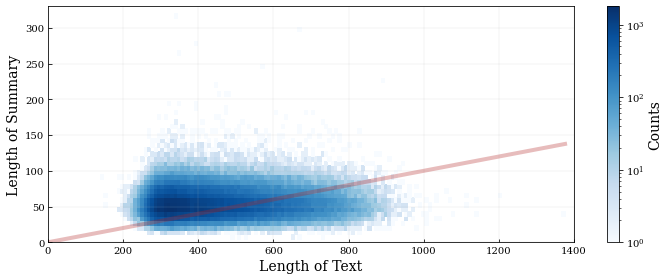

In [ ]:
## Show relations.
plt.rcParams["font.family"] = "serif"

fig, ax = plt.subplots(figsize=(10, 4), facecolor="white", dpi=72)

x = len_text
y = len_summary

x_bins = np.linspace(min(x), max(x), 140)
y_bins = np.linspace(min(y), max(y), 50)

plt.hist2d(x, y, bins=[x_bins, y_bins], cmap="Blues", norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()
cbar.set_label("Counts", fontsize=14)

## y = 0.1 * x
foo = np.linspace(0, max(x), 1000)
bar = foo * 0.1
plt.plot(foo, bar, lw=4, c="firebrick", alpha=.3)

plt.xlim([0, 1400])
plt.ylim([0, 330])
plt.xlabel("Length of Text", fontsize=14)
plt.ylabel("Length of Summary", fontsize=14)

ax.tick_params(axis="both", direction="in")

plt.grid(True, lw=0.15)

plt.tight_layout()
# plt.savefig("2.png", dpi=300)
plt.show()

## **Make Dataset**

### **Tokenizer**

In [ ]:
# del tokenizer

In [ ]:
## Get pretrained tokenizer.
tokenizer = transformers.PreTrainedTokenizerFast.from_pretrained(config.pretrained_model_name)

## Print elements.
print_elements(vars(tokenizer))

{   '_additional_special_tokens': [],
    '_bos_token': '<s>',
    '_cls_token': None,
    '_decode_use_source_tokenizer': False,
    '_eos_token': '</s>',
    '_mask_token': '<mask>',
    '_pad_token': '<pad>',
    '_pad_token_type_id': 0,
    '_sep_token': None,
    '_tokenizer': <tokenizers.Tokenizer object at 0x5607a794d680>,
    '_unk_token': '<unk>',
    'deprecation_warnings': {},
    'init_inputs': (),
    'init_kwargs': {   'name_or_path': 'gogamza/kobart-base-v1',
                       'special_tokens_map_file': '/root/.cache/huggingface/transformers/3e6abf40f4fadbea9e7b539c182868d979838d8f7e6cdcdf2ed52ddcf01420c0.15447ae63ad4a2eba8bc7a5146360711dc32b315b4f1488b4806debf35315e9a'},
    'model_input_names': ['input_ids', 'token_type_ids', 'attention_mask'],
    'model_max_length': 1000000000000000019884624838656,
    'name_or_path': 'gogamza/kobart-base-v1',
    'padding_side': 'right',
    'verbose': True}


### **Dataset and Collater**

`TextAbstractSummarizationDataset`에서는 훈련 전 모든 토크나이징을 미리 진행하게 됩니다. 이때 토크나이징 된 입력의 길이를 내림차순으로 정렬함으로써 배치 단위로 비슷한 길이의 입력끼리 묶일 수 있도록 할 뿐만 아니라 훈련 초기에 Out-Of-Memory (OOM)을 검출할 수 있도록 유도하였습니다.

`TextAbstractSummarizationCollator`에서는 가변길이의 배치 단위의 최대 길이로 패딩을 적용함으로써 배치 단위의 병렬 연산이 가능하게끔 변환합니다. 고정된 길이(1024 등)가 아닌 배치 단위의 최대 길이로 패딩을 적용함으로써, 훈련 및 검증 속도를 향상시킬 수 있었습니다.


HuggingFace PLM을 이용한 훈련 과정을 처음 접했다면 가장 혼란을 겪으실 부분이 데이터 세트 구축 간 입출력 인자를 맞추는 일이라고 생각합니다. `transformers.BartForConditionalGeneration.forward()`의 인자는 [HuggingFace Document](https://huggingface.co/docs/transformers/model_doc/bart#transformers.BartForConditionalGeneration)에서 확인하실 수 있습니다.

In [ ]:
def read_tsv(fpath: pathlib.PosixPath) -> pd.DataFrame:
    return pd.read_csv(fpath, index_col=False, sep="\t", encoding="utf-8")

In [ ]:
class TextAbstractSummarizationDataset(torch.utils.data.Dataset):

    def __init__(
        self,
        tokenizer,
        fpath: pathlib.PosixPath,
        mode: str = "train",
    ):
        super(TextAbstractSummarizationDataset, self).__init__()

        self.df = read_tsv(fpath)
        # self.tok = tokenizer -> don't keep
        
        ## Mode.
        assert mode in ["train", "test"]
        self.mode = mode

        ## Apply tokenize first to speed up in training phase and make code more simply.
        tqdm.pandas(desc="Tokenizing input texts")
        self.df.loc[:, "text_tok"] = self.df.loc[:, "text"].progress_apply(lambda x: tokenizer.encode(x))
        self.df.loc[:, "text_tok_len"] = self.df.loc[:, "text_tok"].apply(lambda x: len(x))

        if self.mode == "train":
            tqdm.pandas(desc="Tokenizing target summaries")
            self.df.loc[:, "summary_tok"] = self.df.loc[:, "summary"].progress_apply(lambda x: tokenizer.encode(x))
            self.df.loc[:, "summary_tok_len"] = self.df.loc[:, "summary_tok"].apply(lambda x: len(x))

        ## Sort by tokenized length with tqdm progress bar.
        ## 
        ## By sorting sequentially, starting with the longest sentence, 
        ## we can determine the maximum VRAM size the model is using for
        ## training. That is, if OOM does not occur for the maximum VRAM
        ## size at the beginning of training, it is guaranteed that OOM
        ## does not occur during training.
        self.df.sort_values(by=["text_tok_len"], axis=0, ascending=False, inplace=True)

    
    def __len__(self) -> int:
        return self.df.shape[0]


    def __getitem__(self, idx: int) -> Dict[str, List[int]]:
        instance = self.df.iloc[idx]

        return_value = {
            "id": instance["id"], ## for sorting in inference mode
            "text": instance["text_tok"],
            "length": len(instance["text_tok"]),
        }
        if self.mode == "train":
            return_value["summary"] = instance["summary_tok"]
        
        return return_value


class TextAbstractSummarizationCollator():

    def __init__(
        self,
        bos_token_id: int,
        eos_token_id: int,
        pad_token_id: int,
        inp_max_len: int = 1024,
        tar_max_len: int = 256,
        ignore_index: int = -100,
        mode: str = "train",
    ):
        super(TextAbstractSummarizationCollator, self).__init__()

        self.bos_token_id = bos_token_id
        self.eos_token_id = eos_token_id
        self.pad_token_id = pad_token_id
        self.inp_max_len = inp_max_len
        self.tar_max_len = tar_max_len
        self.ignore_index = ignore_index

        ## Mode.
        assert mode in ["train", "test"]
        self.mode = mode


    def _pad(self, sentences: List[List[int]], token_id: int) -> np.ndarray:
        ## We will pad as max length per batch, not "inp_max_len(=1024, etc)".
        max_length_per_batch = max([len(i) for i in sentences])

        ## Stack as dimension 0 (batch dimension).
        ## "token_id" can be "tokenizer.pad_token_id(=3)" or "ignore_index(=-100)"
        return np.stack([i + [token_id] * (max_length_per_batch - len(i)) for i in sentences], axis=0)


    def _train_collator(self, samples: List[Dict[str, List[int]]]) -> Dict[str, List[int]]:
        ## Unpack.

        ## If input max length > 1024, you can see below error:
        ##   1) Assertion `srcIndex < srcSelectDimSize` failed
        ##   2) Device-side assert triggered
        tokenized_texts     = [s["text"][:self.inp_max_len]        for s in samples]
        tokenized_summaries = [s["summary"][:self.tar_max_len - 1] for s in samples] ## <bos> or <eos> token index

        ## Inputs for encoder.
        input_ids = self._pad(tokenized_texts, token_id=self.pad_token_id)  ## numpy format
        attention_mask = (input_ids != self.pad_token_id).astype(float)     ## numpy format

        ## Inputs for decoder (generator).
        decoder_input_ids = [[self.bos_token_id] + i for i in tokenized_summaries]      ## bos
        decoder_input_ids = self._pad(decoder_input_ids, token_id=self.pad_token_id)    ## eos
        decoder_attention_mask = (decoder_input_ids != self.pad_token_id).astype(float)

        ## Answer.
        labels = [i + [self.eos_token_id] for i in tokenized_summaries]
        labels = self._pad(labels, token_id=self.ignore_index) ## why != "padding_id" ???

        ## We ensure that generator's inputs' and outputs' shapes are equal.
        assert decoder_input_ids.shape == labels.shape
        
        ## Pack as pre-defined arguments. See:
        ##   https://huggingface.co/docs/transformers/model_doc/bart#transformers.BartForConditionalGeneration
        return {
            "input_ids":                torch.from_numpy(input_ids),
            "attention_mask":           torch.from_numpy(attention_mask),
            "decoder_input_ids":        torch.from_numpy(decoder_input_ids),
            "decoder_attention_mask":   torch.from_numpy(decoder_attention_mask),
            "labels":                   torch.from_numpy(labels),
        }


    def _test_collator(self, samples: List[Dict[str, List[int]]]) -> Dict[str, List[int]]:
        ## Unpack.
        ids              = [s["id"]                      for s in samples]
        tokenized_texts  = [s["text"][:self.inp_max_len] for s in samples]   ## no <bos> token included

        ## Inputs for encoder.
        input_ids = self._pad(tokenized_texts, token_id=self.pad_token_id)  ## numpy format
        attention_mask = (input_ids != self.pad_token_id).astype(float)     ## numpy format

        ## Pack as pre-defined arguments:
        ## See: https://huggingface.co/docs/transformers/model_doc/bart#transformers.BartForConditionalGeneration
        return {
            "input_ids":        torch.from_numpy(input_ids),
            "attention_mask":   torch.from_numpy(attention_mask),
            ## Additional information to make answer.
            "id":               ids,
        }


    def __call__(self, samples: List[Dict[str, List[int]]]) -> Dict[str, List[int]]:
        return self._train_collator(samples) if self.mode == "train" else self._test_collator(samples)


def get_datasets(tokenizer, fpath: pathlib.PosixPath, mode: str = "train"):
    return TextAbstractSummarizationDataset(tokenizer, fpath, mode=mode)

In [ ]:
## Get datasets and index to label map.
tr_ds = get_datasets(tokenizer, fpath=Path(config.train))
vl_ds = get_datasets(tokenizer, fpath=Path(config.valid))

Tokenizing target summaries: 100%|██████████| 2711/2711 [00:00<00:00, 6060.51it/s]


In [ ]:
len(tr_ds), len(vl_ds)

(24398, 2711)

### **Pretrained Language Model**

PLM으로는 HuggingFace에 게시된 [gogamza/kobart-base-v1](https://huggingface.co/gogamza/kobart-base-v1)을 사용합니다.

기타 추천하는 모델들은 다음과 같습니다.
  - gogamza/kobart-base-v1
  - gogamza/kobart-base-v2
  - gogamza/kobart-summarization
  - skt/kobert-base-v1
  - ainize/kobart-news
  - hyunwoongko/kobart

아주 간단한 BART 기반의 모델만을 사용했는데, 문서 요약을 목적으로 고안된 구조인 [PEGASUS](https://arxiv.org/abs/1912.08777), [BERTSumExtAbs](https://arxiv.org/abs/1908.08345) 등을 사용한다면 더 높은 성능을 기대할 수 있을 것입니다.

In [ ]:
model = transformers.BartForConditionalGeneration.from_pretrained(config.pretrained_model_name)

### **Train Arguments**

훈련을 위한 Engine으로는 HuggingFace의 Trainer를 사용합니다.

In [ ]:
## Path arguments.
nowtime = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
output_dir = Path(config.ckpt, nowtime)
logging_dir = Path(config.logs, nowtime, "run")

training_args = transformers.Seq2SeqTrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    per_device_train_batch_size=config.per_replica_batch_size,
    per_device_eval_batch_size=config.per_replica_batch_size,
    gradient_accumulation_steps=config.gradient_accumulation_steps,
    learning_rate=config.lr,
    weight_decay=config.weight_decay,
    warmup_ratio=config.warmup_ratio,
    num_train_epochs=config.n_epochs,
    logging_dir=logging_dir,
    logging_strategy="steps",
    logging_steps=10,
    save_strategy="epoch",
    # save_steps=1000,
    fp16=True,
    dataloader_num_workers=4,
    disable_tqdm=False,
    load_best_model_at_end=True,
    ## As below, only Seq2SeqTrainingArguments' arguments.
    # sortish_sampler=True,
    # predict_with_generate=True,
    # generation_max_length=config.tar_max_len,   ## 256
    # generation_num_beams=config.beam_size,      ## 5
)

## Print elements.
print_elements(vars(training_args))

{   '__cached__setup_devices': device(type='cuda', index=0),
    '_n_gpu': 1,
    'adafactor': False,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999,
    'adam_epsilon': 1e-08,
    'bf16': False,
    'bf16_full_eval': False,
    'dataloader_drop_last': False,
    'dataloader_num_workers': 4,
    'dataloader_pin_memory': True,
    'ddp_bucket_cap_mb': None,
    'ddp_find_unused_parameters': None,
    'debug': [],
    'deepspeed': None,
    'disable_tqdm': False,
    'do_eval': True,
    'do_predict': False,
    'do_train': False,
    'eval_accumulation_steps': None,
    'eval_steps': None,
    'evaluation_strategy': <IntervalStrategy.EPOCH: 'epoch'>,
    'fp16': True,
    'fp16_backend': 'auto',
    'fp16_full_eval': False,
    'fp16_opt_level': 'O1',
    'generation_max_length': None,
    'generation_num_beams': None,
    'gradient_accumulation_steps': 16,
    'gradient_checkpointing': False,
    'greater_is_better': False,
    'group_by_length': False,
    'half_precision_backend': 'a

### **HuggingFace Trainer**

In [ ]:
## Define trainer.
trainer = transformers.Trainer(
    model=model,
    args=training_args,
    data_collator=TextAbstractSummarizationCollator(
        bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
        inp_max_len=config.inp_max_len,
        tar_max_len=config.tar_max_len,
    ),
    train_dataset=tr_ds,
    eval_dataset=vl_ds,
)

Using amp half precision backend


## **Train**

훈련을 진행하는 것은 매우 간단합니다.

HuggingFace의 Trainer는 시각화 부분이 다소 약하다는 의견이 있는데, 저도 그 의견에 어느 정도 동의합니다. 좀 더 괜찮은 TQDM Progress Bar를 사용했더라면 좋을 것 같아 커스터마이징 할 수 있는지 좀 찾아봤는데, 그러한 내용이 지원되지 않아 조금 아쉬웠습니다.

In [ ]:
## Just train.
trainer.train()

***** Running training *****
  Num examples = 24398
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Gradient Accumulation steps = 16
  Total optimization steps = 1900


Epoch,Training Loss,Validation Loss
0,1.559200,1.543973
1,1.417500,1.446895
2,1.298000,1.415649
3,1.181800,1.419801
4,1.069600,1.439469
5,1.025500,1.447175
6,0.940600,1.480663
7,0.877700,1.495439
8,0.845500,1.507249
9,0.816700,1.520043


***** Running Evaluation *****
  Num examples = 2711
  Batch size = 8
Saving model checkpoint to ckpt/20211227-042519/checkpoint-190
Configuration saved in ckpt/20211227-042519/checkpoint-190/config.json
Model weights saved in ckpt/20211227-042519/checkpoint-190/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2711
  Batch size = 8
Saving model checkpoint to ckpt/20211227-042519/checkpoint-380
Configuration saved in ckpt/20211227-042519/checkpoint-380/config.json
Model weights saved in ckpt/20211227-042519/checkpoint-380/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2711
  Batch size = 8
Saving model checkpoint to ckpt/20211227-042519/checkpoint-570
Configuration saved in ckpt/20211227-042519/checkpoint-570/config.json
Model weights saved in ckpt/20211227-042519/checkpoint-570/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 2711
  Batch size = 8
Saving model checkpoint to ckpt/20211227-042519/checkpoint-760
Configuration saved in c

TrainOutput(global_step=1900, training_loss=1.213880800196999, metrics={'train_runtime': 13715.9503, 'train_samples_per_second': 17.788, 'train_steps_per_second': 0.139, 'total_flos': 9.382096101740544e+16, 'train_loss': 1.213880800196999, 'epoch': 10.0})

### **Visualize to TensorBoard**

### **(Optional) Upload Logs**

In [ ]:
# %%bash
# tensorboard dev upload --logdir ./logs \
#     --name {SOME_MODEL_NAME} \
#     --description {SOME_MODEL_TITLE} \
#     --one_shot

### **Save Best Model**

앞서 `'load_best_model_at_end': True`로 설정했으므로 모델에는 latest weight가 저장되어 있을 것이고, 이를 `torch.save()`를 사용하여 별도로 google drive에 저장 및 호출합니다. 물론 Trainer에서 저장한 체크포인트 `*.bin`을 사용할 수도 있습니다.

In [ ]:
## Save the best model to your gdrive.
torch.save({
    "model": trainer.model.state_dict(),
    "config": config,
    "tokenizer": tokenizer,
}, Path(config.model_fpath))

## **Inference**

### **Load Latest Model**

In [ ]:
saved_data = torch.load(
    config.model_fpath,
    map_location="cpu" if config.gpu_id < 0 else "cuda:%d" % config.gpu_id,
)

In [ ]:
## Parse.
bart_best = saved_data["model"]
train_config = saved_data["config"]
tokenizer = transformers.PreTrainedTokenizerFast.from_pretrained(train_config.pretrained_model_name)

## Load weights.
model = transformers.BartForConditionalGeneration.from_pretrained(train_config.pretrained_model_name)
model.load_state_dict(bart_best)

### **Get Test Dataset**

In [ ]:
ts_ds = get_datasets(tokenizer, fpath=Path(config.test), mode="test")

## We will use pytorch dataloader, not huggingface trainer.
ts_loader = torch.utils.data.DataLoader(
    ts_ds,
    batch_size=config.per_replica_batch_size,
    shuffle=False,
    num_workers=4,
    collate_fn=TextAbstractSummarizationCollator(
        bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
        inp_max_len=config.inp_max_len,
        tar_max_len=config.tar_max_len,
        mode="test",
    ),
)

Tokenizing input texts: 100%|██████████| 302/302 [00:00<00:00, 1002.83it/s]


### **Generate Summaries**

추론 과정은 `torch.no_grad()`를 사용하여 직접 raw level로 구현합니다.

훈련 과정과 마찬가지로 문서를 길이별로 정렬하여 추론한 뒤, `id`별로 재정렬하여 제출 포멧을 맞춥니다.

HuggingFace 모델에서의 추론은 `transformers.BartForConditionalGeneration.generate()`를 사용하여 진행되며, 구체적인 인자의 값은 [HuggingFace Document](https://huggingface.co/docs/transformers/v4.15.0/en/main_classes/model#transformers.generation_utils.GenerationMixin.generate)를 참조하시면 될 것 같습니다. 실제로 Beam Search, Trigram Blocking 등과 같은 내용들은 모두 구현되어 있습니다.

In [ ]:
with torch.no_grad():
    if config.gpu_id >= 0:
        model.cuda(config.gpu_id)
    device = next(model.parameters()).device

    ## Don't forget turn-on evaluation mode.
    model.eval()

    outputs = []
    for mini_batch in tqdm(ts_loader, total=len(ts_loader)):
        id = mini_batch["id"]
        input_ids = mini_batch["input_ids"]
        attention_mask = mini_batch["attention_mask"]

        if config.var_len:
            ## Variable min, max length of target summaries.
            ## We know that summaries ~= text * 0.1.
            avg_len = int(input_ids.ne(tokenizer.pad_token_id).view(-1).sum() / input_ids.size(0))
            min_length = max(64,  int(avg_len * 0.05))
            max_length = min(256, int(avg_len * 0.15))
            ## And we don't need to set length penalty anymore.
            config.length_penalty = 1.0
        else:
            min_length = config.tar_max_len // 4 ## maybe, less then 64 (e.g. 48 or 32) can be more score..
            max_length = config.tar_max_len

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        ## Generate ids of summaries.
        output = model.generate(
            input_ids, 
            attention_mask=attention_mask,
            max_length=max_length,                  ## maximum summarization size
            min_length=min_length,                  ## minimum summarization size
            early_stopping=True,                    ## stop the beam search when at least 'num_beams' sentences are finished per batch
            num_beams=config.beam_size,             ## beam search size
            bos_token_id=tokenizer.bos_token_id,    ## <s> = 0
            eos_token_id=tokenizer.eos_token_id,    ## <\s> = 1
            pad_token_id=tokenizer.pad_token_id,    ## 3
            length_penalty=config.length_penalty,   ## value > 1.0 in order to encourage the model to produce longer sequences
            no_repeat_ngram_size=config.no_repeat_ngram_size,   ## same as 'trigram blocking'
        )
        ## If you want to decode by each sentence, you may 
        ## call 'decode' fn, not 'batch_decode'.
        output = tokenizer.batch_decode(
            output.tolist(), 
            skip_special_tokens=True,
        )

        ## Get all.
        outputs.extend([{"id": id_, "output": output_} for id_, output_ in zip(id, output)])

## Sort and extract.
outputs = sorted(
    outputs,
    key=itemgetter("id"),
    reverse=False,
)
outputs = [i["output"] for i in outputs]

100%|██████████| 38/38 [01:12<00:00,  1.90s/it]


In [ ]:
outputs[0]

"한국카카오은행(카카오뱅크)은 '모임통장 서비스' 이용자가 출시 한달 만에 100만명을 넘어섰다고 7일 밝히며 동호회, 동아리 등 모임의 회비를 투명하고 편리하게 관리할 수 있어 인기를 끌고 있다고 전하며 계좌당 평균 3.01명 이상이 회비 현황을 공유하고 있는 것으로 나타났다."

### **Save Prediction**

예측문을 저장하며, 별도의 후처리는 적용하지 않았습니다.

In [ ]:
def save_predictions(sample_submission_path: pathlib.PosixPath, predictions: List[Dict[str, str]], save_to: pathlib.PosixPath) -> pathlib.PosixPath:
    ## Read a sample file.
    df = pd.read_csv(sample_submission_path, index_col=False, sep="\t", encoding="utf-8")

    ## Record it.
    ## Thus test datasets are already sorted by 'id', we don't need to
    ## worry about shuffing.
    # try:
    #     df.loc[:, "summary"] = np.array(predictions)
    # except Exception as e:
    #     print(e)
    #     df.iloc[:len(np.array(predictions)), 1:] = np.array(predictions)
    df.loc[:, "summary"] = np.array(predictions)
    
    ## Strip.
    df.loc[:, "summary"] = df.loc[:, "summary"].apply(lambda x: x.strip())

    ## Save.
    save_to.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(save_to, index=False, sep="\t", encoding="utf-8")

In [ ]:
save_to = Path.cwd() / Path(config.prediction_path)
save_predictions(
    sample_submission_path=config.sample_submission_path, 
    predictions=outputs,
    save_to=save_to,
)
print(f"Submission save to: {save_to}")

Submission save to: /content/prediction.tsv


In [ ]:
try:
    from google.colab import files
    files.download("answer.tsv")
    files.download("prediction.tsv")
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Calculate Rouge Scores**

* https://dacon.io/competitions/official/235673/talkboard/401911?page=1&dtype=recent

### **Install Mecab**

* https://sosomemo.tistory.com/30

In [ ]:
%%bash
cd /tmp
sudo wget https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
sudo tar xvf mecab-0.996-ko-0.9.2.tar.gz

cd /tmp/mecab-0.996-ko-0.9.2
sudo ./configure
sudo make check
sudo make install

In [ ]:
%%bash
cd /tmp
wget https://bitbucket.org/eunjeon/mecab-ko-dic/downloads/mecab-ko-dic-2.1.1-20180720.tar.gz
tar zxvf mecab-ko-dic-2.1.1-20180720.tar.gz

cd /tmp/mecab-ko-dic-2.1.1-20180720
sudo ./autogen.sh
sudo ./configure
sudo make
sudo make install

In [ ]:
%%bash
cd /tmp
git clone https://bitbucket.org/eunjeon/mecab-python-0.996.git
cd mecab-python-0.996
python3 setup.py build
python3 setup.py install

### **Define Main Functions**

데이콘에서 공식적으로 안내해주신 [평가용 코드](https://dacon.io/competitions/official/235673/talkboard/401911?page=1&dtype=recent)를 그대로 사용합니다.

In [ ]:
!pip install konlpy

In [ ]:
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

In [ ]:
import konlpy
from konlpy.tag import Mecab

In [ ]:
import os
import re
import platform
import itertools
import collections
import pkg_resources  # pip install py-rouge
from io import open


if platform.system() == "Windows":
    try:
        from eunjeon import Mecab
    except:
        print("please install eunjeon module")
else:  # Ubuntu일 경우
    from konlpy.tag import Mecab




class Rouge:
    DEFAULT_METRICS = {"rouge-n"}
    DEFAULT_N = 1
    STATS = ["f", "p", "r"]
    AVAILABLE_METRICS = {"rouge-n", "rouge-l", "rouge-w"}
    AVAILABLE_LENGTH_LIMIT_TYPES = {"words", "bytes"}
    REMOVE_CHAR_PATTERN = re.compile("[^A-Za-z0-9가-힣]")


    def __init__(
        self,
        metrics=None,
        max_n=None,
        limit_length=True,
        length_limit=1000,
        length_limit_type="words",
        apply_avg=True,
        apply_best=False,
        use_tokenizer=True,
        alpha=0.5,
        weight_factor=1.0,
    ):
        self.metrics = metrics[:] if metrics is not None else Rouge.DEFAULT_METRICS
        for m in self.metrics:
            if m not in Rouge.AVAILABLE_METRICS:
                raise ValueError("Unknown metric '{}'".format(m))


        self.max_n = max_n if "rouge-n" in self.metrics else None
        # Add all rouge-n metrics
        if self.max_n is not None:
            index_rouge_n = self.metrics.index("rouge-n")
            del self.metrics[index_rouge_n]
            self.metrics += ["rouge-{}".format(n) for n in range(1, self.max_n + 1)]
        self.metrics = set(self.metrics)


        self.limit_length = limit_length
        if self.limit_length:
            if length_limit_type not in Rouge.AVAILABLE_LENGTH_LIMIT_TYPES:
                raise ValueError("Unknown length_limit_type '{}'".format(length_limit_type))


        self.length_limit = length_limit
        if self.length_limit == 0:
            self.limit_length = False
        self.length_limit_type = length_limit_type


        self.use_tokenizer = use_tokenizer
        if use_tokenizer:
            self.tokenizer = Mecab()


        self.apply_avg = apply_avg
        self.apply_best = apply_best
        self.alpha = alpha
        self.weight_factor = weight_factor
        if self.weight_factor <= 0:
            raise ValueError("ROUGE-W weight factor must greater than 0.")


    def tokenize_text(self, text):
        if self.use_tokenizer:
            return self.tokenizer.morphs(text)
        else:
            return text


    @staticmethod
    def split_into_sentences(text):
        return text.split("\n")


    @staticmethod
    def _get_ngrams(n, text):
        ngram_set = collections.defaultdict(int)
        max_index_ngram_start = len(text) - n
        for i in range(max_index_ngram_start + 1):
            ngram_set[tuple(text[i : i + n])] += 1
        return ngram_set


    @staticmethod
    def _split_into_words(sentences):
        return list(itertools.chain(*[_.split() for _ in sentences]))


    @staticmethod
    def _get_word_ngrams_and_length(n, sentences):
        assert len(sentences) > 0
        assert n > 0


        tokens = Rouge._split_into_words(sentences)
        return Rouge._get_ngrams(n, tokens), tokens, len(tokens) - (n - 1)


    @staticmethod
    def _get_unigrams(sentences):
        assert len(sentences) > 0


        tokens = Rouge._split_into_words(sentences)
        unigram_set = collections.defaultdict(int)
        for token in tokens:
            unigram_set[token] += 1
        return unigram_set, len(tokens)


    @staticmethod
    def _compute_p_r_f_score(
        evaluated_count,
        reference_count,
        overlapping_count,
        alpha=0.5,
        weight_factor=1.0,
    ):
        precision = 0.0 if evaluated_count == 0 else overlapping_count / float(evaluated_count)
        if weight_factor != 1.0:
            precision = precision ** (1.0 / weight_factor)
        recall = 0.0 if reference_count == 0 else overlapping_count / float(reference_count)
        if weight_factor != 1.0:
            recall = recall ** (1.0 / weight_factor)
        f1_score = Rouge._compute_f_score(precision, recall, alpha)
        return {"f": f1_score, "p": precision, "r": recall}


    @staticmethod
    def _compute_f_score(precision, recall, alpha=0.5):
        return (
            0.0
            if (recall == 0.0 or precision == 0.0)
            else precision * recall / ((1 - alpha) * precision + alpha * recall)
        )


    @staticmethod
    def _compute_ngrams(evaluated_sentences, reference_sentences, n):
        if len(evaluated_sentences) <= 0 or len(reference_sentences) <= 0:
            raise ValueError("Collections must contain at least 1 sentence.")


        evaluated_ngrams, _, evaluated_count = Rouge._get_word_ngrams_and_length(
            n, evaluated_sentences
        )
        reference_ngrams, _, reference_count = Rouge._get_word_ngrams_and_length(
            n, reference_sentences
        )


        # Gets the overlapping ngrams between evaluated and reference
        overlapping_ngrams = set(evaluated_ngrams.keys()).intersection(set(reference_ngrams.keys()))
        overlapping_count = 0
        for ngram in overlapping_ngrams:
            overlapping_count += min(evaluated_ngrams[ngram], reference_ngrams[ngram])


        return evaluated_count, reference_count, overlapping_count


    @staticmethod
    def _compute_ngrams_lcs(evaluated_sentences, reference_sentences, weight_factor=1.0):
        def _lcs(x, y):
            m = len(x)
            n = len(y)
            vals = collections.defaultdict(int)
            dirs = collections.defaultdict(int)


            for i in range(1, m + 1):
                for j in range(1, n + 1):
                    if x[i - 1] == y[j - 1]:
                        vals[i, j] = vals[i - 1, j - 1] + 1
                        dirs[i, j] = "|"
                    elif vals[i - 1, j] >= vals[i, j - 1]:
                        vals[i, j] = vals[i - 1, j]
                        dirs[i, j] = "^"
                    else:
                        vals[i, j] = vals[i, j - 1]
                        dirs[i, j] = "<"


            return vals, dirs


        def _wlcs(x, y, weight_factor):
            m = len(x)
            n = len(y)
            vals = collections.defaultdict(float)
            dirs = collections.defaultdict(int)
            lengths = collections.defaultdict(int)


            for i in range(1, m + 1):
                for j in range(1, n + 1):
                    if x[i - 1] == y[j - 1]:
                        length_tmp = lengths[i - 1, j - 1]
                        vals[i, j] = (
                            vals[i - 1, j - 1]
                            + (length_tmp + 1) ** weight_factor
                            - length_tmp ** weight_factor
                        )
                        dirs[i, j] = "|"
                        lengths[i, j] = length_tmp + 1
                    elif vals[i - 1, j] >= vals[i, j - 1]:
                        vals[i, j] = vals[i - 1, j]
                        dirs[i, j] = "^"
                        lengths[i, j] = 0
                    else:
                        vals[i, j] = vals[i, j - 1]
                        dirs[i, j] = "<"
                        lengths[i, j] = 0


            return vals, dirs


        def _mark_lcs(mask, dirs, m, n):
            while m != 0 and n != 0:
                if dirs[m, n] == "|":
                    m -= 1
                    n -= 1
                    mask[m] = 1
                elif dirs[m, n] == "^":
                    m -= 1
                elif dirs[m, n] == "<":
                    n -= 1
                else:
                    raise UnboundLocalError("Illegal move")


            return mask


        if len(evaluated_sentences) <= 0 or len(reference_sentences) <= 0:
            raise ValueError("Collections must contain at least 1 sentence.")


        evaluated_unigrams_dict, evaluated_count = Rouge._get_unigrams(evaluated_sentences)
        reference_unigrams_dict, reference_count = Rouge._get_unigrams(reference_sentences)


        # Has to use weight factor for WLCS
        use_WLCS = weight_factor != 1.0
        if use_WLCS:
            evaluated_count = evaluated_count ** weight_factor
            reference_count = 0


        overlapping_count = 0.0
        for reference_sentence in reference_sentences:
            reference_sentence_tokens = reference_sentence.split()
            if use_WLCS:
                reference_count += len(reference_sentence_tokens) ** weight_factor
            hit_mask = [0 for _ in range(len(reference_sentence_tokens))]


            for evaluated_sentence in evaluated_sentences:
                evaluated_sentence_tokens = evaluated_sentence.split()


                if use_WLCS:
                    _, lcs_dirs = _wlcs(
                        reference_sentence_tokens,
                        evaluated_sentence_tokens,
                        weight_factor,
                    )
                else:
                    _, lcs_dirs = _lcs(reference_sentence_tokens, evaluated_sentence_tokens)
                _mark_lcs(
                    hit_mask,
                    lcs_dirs,
                    len(reference_sentence_tokens),
                    len(evaluated_sentence_tokens),
                )


            overlapping_count_length = 0
            for ref_token_id, val in enumerate(hit_mask):
                if val == 1:
                    token = reference_sentence_tokens[ref_token_id]
                    if evaluated_unigrams_dict[token] > 0 and reference_unigrams_dict[token] > 0:
                        evaluated_unigrams_dict[token] -= 1
                        reference_unigrams_dict[ref_token_id] -= 1


                        if use_WLCS:
                            overlapping_count_length += 1
                            if (
                                ref_token_id + 1 < len(hit_mask) and hit_mask[ref_token_id + 1] == 0
                            ) or ref_token_id + 1 == len(hit_mask):
                                overlapping_count += overlapping_count_length ** weight_factor
                                overlapping_count_length = 0
                        else:
                            overlapping_count += 1


        if use_WLCS:
            reference_count = reference_count ** weight_factor


        return evaluated_count, reference_count, overlapping_count


    def get_scores(self, hypothesis, references):
        if isinstance(hypothesis, str):
            hypothesis, references = [hypothesis], [references]


        if type(hypothesis) != type(references):
            raise ValueError("'hyps' and 'refs' are not of the same type")


        if len(hypothesis) != len(references):
            raise ValueError("'hyps' and 'refs' do not have the same length")
        scores = {}
        has_rouge_n_metric = (
            len([metric for metric in self.metrics if metric.split("-")[-1].isdigit()]) > 0
        )
        if has_rouge_n_metric:
            scores.update(self._get_scores_rouge_n(hypothesis, references))
            # scores = {**scores, **self._get_scores_rouge_n(hypothesis, references)}


        has_rouge_l_metric = (
            len([metric for metric in self.metrics if metric.split("-")[-1].lower() == "l"]) > 0
        )
        if has_rouge_l_metric:
            scores.update(self._get_scores_rouge_l_or_w(hypothesis, references, False))
            # scores = {**scores, **self._get_scores_rouge_l_or_w(hypothesis, references, False)}


        has_rouge_w_metric = (
            len([metric for metric in self.metrics if metric.split("-")[-1].lower() == "w"]) > 0
        )
        if has_rouge_w_metric:
            scores.update(self._get_scores_rouge_l_or_w(hypothesis, references, True))
            # scores = {**scores, **self._get_scores_rouge_l_or_w(hypothesis, references, True)}


        return scores


    def _get_scores_rouge_n(self, all_hypothesis, all_references):
        metrics = [metric for metric in self.metrics if metric.split("-")[-1].isdigit()]


        if self.apply_avg or self.apply_best:
            scores = {metric: {stat: 0.0 for stat in Rouge.STATS} for metric in metrics}
        else:
            scores = {
                metric: [{stat: [] for stat in Rouge.STATS} for _ in range(len(all_hypothesis))]
                for metric in metrics
            }


        for sample_id, (hypothesis, references) in enumerate(zip(all_hypothesis, all_references)):
            assert isinstance(hypothesis, str)
            has_multiple_references = False
            if isinstance(references, list):
                has_multiple_references = len(references) > 1
                if not has_multiple_references:
                    references = references[0]


            # Prepare hypothesis and reference(s)
            hypothesis = self._preprocess_summary_as_a_whole(hypothesis)
            references = (
                [self._preprocess_summary_as_a_whole(reference) for reference in references]
                if has_multiple_references
                else [self._preprocess_summary_as_a_whole(references)]
            )


            # Compute scores
            for metric in metrics:
                suffix = metric.split("-")[-1]
                n = int(suffix)


                # Aggregate
                if self.apply_avg:
                    # average model
                    total_hypothesis_ngrams_count = 0
                    total_reference_ngrams_count = 0
                    total_ngrams_overlapping_count = 0


                    for reference in references:
                        (
                            hypothesis_count,
                            reference_count,
                            overlapping_ngrams,
                        ) = Rouge._compute_ngrams(hypothesis, reference, n)
                        total_hypothesis_ngrams_count += hypothesis_count
                        total_reference_ngrams_count += reference_count
                        total_ngrams_overlapping_count += overlapping_ngrams


                    score = Rouge._compute_p_r_f_score(
                        total_hypothesis_ngrams_count,
                        total_reference_ngrams_count,
                        total_ngrams_overlapping_count,
                        self.alpha,
                    )


                    for stat in Rouge.STATS:
                        scores[metric][stat] += score[stat]
                else:
                    # Best model
                    if self.apply_best:
                        best_current_score = None
                        for reference in references:
                            (
                                hypothesis_count,
                                reference_count,
                                overlapping_ngrams,
                            ) = Rouge._compute_ngrams(hypothesis, reference, n)
                            score = Rouge._compute_p_r_f_score(
                                hypothesis_count,
                                reference_count,
                                overlapping_ngrams,
                                self.alpha,
                            )
                            if best_current_score is None or score["r"] > best_current_score["r"]:
                                best_current_score = score


                        for stat in Rouge.STATS:
                            scores[metric][stat] += best_current_score[stat]
                    # Keep all
                    else:
                        for reference in references:
                            (
                                hypothesis_count,
                                reference_count,
                                overlapping_ngrams,
                            ) = Rouge._compute_ngrams(hypothesis, reference, n)
                            score = Rouge._compute_p_r_f_score(
                                hypothesis_count,
                                reference_count,
                                overlapping_ngrams,
                                self.alpha,
                            )
                            for stat in Rouge.STATS:
                                scores[metric][sample_id][stat].append(score[stat])


        # Compute final score with the average or the the max
        if (self.apply_avg or self.apply_best) and len(all_hypothesis) > 1:
            for metric in metrics:
                for stat in Rouge.STATS:
                    scores[metric][stat] /= len(all_hypothesis)


        return scores


    def _get_scores_rouge_l_or_w(self, all_hypothesis, all_references, use_w=False):
        metric = "rouge-w" if use_w else "rouge-l"
        if self.apply_avg or self.apply_best:
            scores = {metric: {stat: 0.0 for stat in Rouge.STATS}}
        else:
            scores = {
                metric: [{stat: [] for stat in Rouge.STATS} for _ in range(len(all_hypothesis))]
            }


        for sample_id, (hypothesis_sentences, references_sentences) in enumerate(
            zip(all_hypothesis, all_references)
        ):
            assert isinstance(hypothesis_sentences, str)
            has_multiple_references = False
            if isinstance(references_sentences, list):
                has_multiple_references = len(references_sentences) > 1
                if not has_multiple_references:
                    references_sentences = references_sentences[0]


            # Prepare hypothesis and reference(s)
            hypothesis_sentences = self._preprocess_summary_per_sentence(hypothesis_sentences)
            references_sentences = (
                [
                    self._preprocess_summary_per_sentence(reference)
                    for reference in references_sentences
                ]
                if has_multiple_references
                else [self._preprocess_summary_per_sentence(references_sentences)]
            )


            # Compute scores
            # Aggregate
            if self.apply_avg:
                # average model
                total_hypothesis_ngrams_count = 0
                total_reference_ngrams_count = 0
                total_ngrams_overlapping_count = 0


                for reference_sentences in references_sentences:
                    (
                        hypothesis_count,
                        reference_count,
                        overlapping_ngrams,
                    ) = Rouge._compute_ngrams_lcs(
                        hypothesis_sentences,
                        reference_sentences,
                        self.weight_factor if use_w else 1.0,
                    )
                    total_hypothesis_ngrams_count += hypothesis_count
                    total_reference_ngrams_count += reference_count
                    total_ngrams_overlapping_count += overlapping_ngrams


                score = Rouge._compute_p_r_f_score(
                    total_hypothesis_ngrams_count,
                    total_reference_ngrams_count,
                    total_ngrams_overlapping_count,
                    self.alpha,
                    self.weight_factor if use_w else 1.0,
                )
                for stat in Rouge.STATS:
                    scores[metric][stat] += score[stat]
            else:
                # Best model
                if self.apply_best:
                    best_current_score = None
                    best_current_score_wlcs = None
                    for reference_sentences in references_sentences:
                        (
                            hypothesis_count,
                            reference_count,
                            overlapping_ngrams,
                        ) = Rouge._compute_ngrams_lcs(
                            hypothesis_sentences,
                            reference_sentences,
                            self.weight_factor if use_w else 1.0,
                        )
                        score = Rouge._compute_p_r_f_score(
                            total_hypothesis_ngrams_count,
                            total_reference_ngrams_count,
                            total_ngrams_overlapping_count,
                            self.alpha,
                            self.weight_factor if use_w else 1.0,
                        )


                        if use_w:
                            reference_count_for_score = reference_count ** (
                                1.0 / self.weight_factor
                            )
                            overlapping_ngrams_for_score = overlapping_ngrams
                            score_wlcs = (
                                overlapping_ngrams_for_score / reference_count_for_score
                            ) ** (1.0 / self.weight_factor)


                            if (
                                best_current_score_wlcs is None
                                or score_wlcs > best_current_score_wlcs
                            ):
                                best_current_score = score
                                best_current_score_wlcs = score_wlcs
                        else:
                            if best_current_score is None or score["r"] > best_current_score["r"]:
                                best_current_score = score


                    for stat in Rouge.STATS:
                        scores[metric][stat] += best_current_score[stat]
                # Keep all
                else:
                    for reference_sentences in references_sentences:
                        (
                            hypothesis_count,
                            reference_count,
                            overlapping_ngrams,
                        ) = Rouge._compute_ngrams_lcs(
                            hypothesis_sentences,
                            reference_sentences,
                            self.weight_factor if use_w else 1.0,
                        )
                        score = Rouge._compute_p_r_f_score(
                            hypothesis_count,
                            reference_count,
                            overlapping_ngrams,
                            self.alpha,
                            self.weight_factor,
                        )


                        for stat in Rouge.STATS:
                            scores[metric][sample_id][stat].append(score[stat])


        # Compute final score with the average or the the max
        if (self.apply_avg or self.apply_best) and len(all_hypothesis) > 1:
            for stat in Rouge.STATS:
                scores[metric][stat] /= len(all_hypothesis)


        return scores


    def _preprocess_summary_as_a_whole(self, summary):
        sentences = Rouge.split_into_sentences(summary)


        # Truncate
        if self.limit_length:
            # By words
            if self.length_limit_type == "words":
                summary = " ".join(sentences)
                all_tokens = summary.split()  # Counting as in the perls script
                summary = " ".join(all_tokens[: self.length_limit])


            # By bytes
            elif self.length_limit_type == "bytes":
                summary = ""
                current_len = 0
                for sentence in sentences:
                    sentence = sentence.strip()
                    sentence_len = len(sentence)


                    if current_len + sentence_len < self.length_limit:
                        if current_len != 0:
                            summary += " "
                        summary += sentence
                        current_len += sentence_len
                    else:
                        if current_len > 0:
                            summary += " "
                        summary += sentence[: self.length_limit - current_len]
                        break
        else:
            summary = " ".join(sentences)


        summary = Rouge.REMOVE_CHAR_PATTERN.sub(" ", summary.lower()).strip()


        tokens = self.tokenize_text(Rouge.REMOVE_CHAR_PATTERN.sub(" ", summary))
        preprocessed_summary = [" ".join(tokens)]


        return preprocessed_summary


    def _preprocess_summary_per_sentence(self, summary):
        sentences = Rouge.split_into_sentences(summary)


        # Truncate
        if self.limit_length:
            final_sentences = []
            current_len = 0
            # By words
            if self.length_limit_type == "words":
                for sentence in sentences:
                    tokens = sentence.strip().split()
                    tokens_len = len(tokens)
                    if current_len + tokens_len < self.length_limit:
                        sentence = " ".join(tokens)
                        final_sentences.append(sentence)
                        current_len += tokens_len
                    else:
                        sentence = " ".join(tokens[: self.length_limit - current_len])
                        final_sentences.append(sentence)
                        break
            # By bytes
            elif self.length_limit_type == "bytes":
                for sentence in sentences:
                    sentence = sentence.strip()
                    sentence_len = len(sentence)
                    if current_len + sentence_len < self.length_limit:
                        final_sentences.append(sentence)
                        current_len += sentence_len
                    else:
                        sentence = sentence[: self.length_limit - current_len]
                        final_sentences.append(sentence)
                        break
            sentences = final_sentences


        final_sentences = []
        for sentence in sentences:
            sentence = Rouge.REMOVE_CHAR_PATTERN.sub(" ", sentence.lower()).strip()


            tokens = self.tokenize_text(Rouge.REMOVE_CHAR_PATTERN.sub(" ", sentence))


            sentence = " ".join(tokens)


            final_sentences.append(sentence)


        return final_sentences

In [ ]:
import argparse
import pandas as pd
from tqdm import tqdm

class RougeScorer:
    def __init__(self):
        self.rouge_evaluator = Rouge(
            metrics=["rouge-n", "rouge-l"],
            max_n=2,
            limit_length=True,
            length_limit=1000,
            length_limit_type="words",
            use_tokenizer=True,
            apply_avg=True,
            apply_best=False,
            alpha=0.5,  # Default F1_score
            weight_factor=1.2,
        )

    def compute_rouge(self, ref_df, hyp_df):
        #ref_df = pd.read_csv(ref_path)
        #hyp_df = pd.read_csv(hyp_path)
        hyp_df.iloc[:,1] = hyp_df.iloc[:,1].fillna(' ')
        ids = ref_df['id']
        hyp_df = hyp_df[hyp_df['id'].isin(ids)]
        hyp_df.index = ref_df.index

        ref_df = ref_df.sort_values(by=["id"])
        hyp_df = hyp_df.sort_values(by=["id"])
        ref_df["id"] = ref_df["id"].astype(int)
        hyp_df["id"] = hyp_df["id"].astype(int)

        hyps = [tuple(row) for row in hyp_df.values]
        refs = [tuple(row) for row in ref_df.values]

        reference_summaries = []
        generated_summaries = []

        for ref_tp, hyp_tp in zip(refs, hyps):
            ref_id, ref = ref_tp
            hyp_id, hyp = hyp_tp

            assert ref_id == hyp_id

            reference_summaries.append(ref)
            generated_summaries.append(hyp)

        scores = self.rouge_evaluator.get_scores(generated_summaries, reference_summaries)
        str_scores = self.format_rouge_scores(scores)
        #self.save_rouge_scores(str_scores)
        return str_scores

    def save_rouge_scores(self, str_scores):
        with open("rouge_scores.txt", "w") as output:
            output.write(str_scores)

    def format_rouge_scores(self, scores):
    	return "{:.3f},{:.3f},{:.3f}".format(
            scores["rouge-1"]["f"],
            scores["rouge-2"]["f"],
            scores["rouge-l"]["f"],
        )

### **Scoring**

In [ ]:
## Ref: answer.tsv, Hyp: prediction.tsv
ref_df = pd.read_csv(Path.cwd() / Path(config.answer_path), index_col=False, sep="\t", encoding="utf-8")
hyp_df = pd.read_csv(Path.cwd() / Path(config.prediction_path), index_col=False, sep="\t", encoding="utf-8")

In [ ]:
## Compute rouge score.
scorer = RougeScorer()
scores = scorer.compute_rouge(ref_df, hyp_df)

print("\n".join([f"Rouge-{i}: {score}" for i, score in zip([1, 2, "N"], scores.split(","))]))

Rouge-1: 0.490
Rouge-2: 0.311
Rouge-N: 0.376


### **Show Samples**

실제 정답에 비해 요약문이 다소 길게 생성된 것처럼 보이므로, model.generate()의 `min_length` 값을 줄이거나, 혹은 `length_penalty`를 조정할 수 있을 것입니다.

In [ ]:
tmp = ref_df.copy()
tmp = pd.merge(tmp, hyp_df.copy(), how="outer", on="id")
tmp.rename(columns={"summary_x": "label", "summary_y": "prediction"}, inplace=True)
tmp

,id,label,prediction
0,330061292,한국카카오은행(카카오뱅크)이 7일 발표한 내용에 따르면 지난해 12월 3일 출시한 ...,한국카카오은행(카카오뱅크)은 '모임통장 서비스' 이용자가 출시 한달 만에 100만명...
1,330852492,국도 교통부는 국토의 홍수 대응능력을 강화하기 위해 하천설계 기준을 전면 개정하여 ...,"국토교통부는 14일 상습 도시침수지역, 기후변화로 인한 국지성 호우 등에 대한 대비..."
2,332591740,지난 28일 송파구 잠실롯대호텔에서 열린 '2019년 정기총회'에서 8715표 중 ...,28일 잠실 송파구 잠실롯데호텔에서 열린 '2019년 정기총회'에서 서울지방변호사회...
3,333847004,한국산업기술진흥원이 11일 발표한 '글로벌 1000대 기업의 2017년 R&D 투자...,한국산업기술진흥원(KIAT)은 11일 '글로벌 1000대 기업의 2017년 R&D ...
4,334025004,"2학년 수업에 대부분 편성되어 있는 물리학Ⅰ, 화학Ⅰ, 생명과학Ⅰ, 지구과학Ⅰ 수업...",두림학원 박창현 물리 대표강사는 2015 개정교육과정 물리학I은 이전 물리에 비해 ...
...,...,...,...
297,370100982,"LG화학과 산업은행, 수출입은행, 농협은행은 9일 서울 마곡 LG사이언스파크에서 '...","LG화학과 산업은행, 수출입은행, 농협은행은 9일 서울 마곡 LG사이언스파크에서 '..."
298,370421105,"10일 김상도 국토부 종합교통정책관은 정부세종청사 보고에서, 타다 개정안은 기존산업...",국토교통부는 '자동차운수사업법' 개정안에 대한 논란이 '금지'냐 '허용'이냐라는 이...
299,370977175,단속을 피해 달아나던 불법취업 외국인 근로자가 추락사하는 사고가 발생하자 유족은 업...,서울행정법원 행정합의3부(박성규 부장판사)는 A씨 유족이 근로복지공단을 상대로 낸 ...
300,371845887,현대중공업그룹이 연말 막바지 수주 총력전을 펼치며 수주 속도를 내면서 수주목표를 7...,현대중공업그룹은 건조한 가스운반선 현대중공업그룹은 최근 해외 선사로부터 17만400...


In [ ]:
for _, instance in tmp.sample(n=3).iterrows():
    print(f"id: {instance['id']}")
    print(f"  label: {instance['label']}")
    print(f"  prediction: {instance['prediction']}")
    print()

id: 356915849
  label: 모테기 도시미츠 일본 경제재정재생상과 라이트 하이저 미국 통상대표부(USTR) 대표가 21일부터 미국 워싱턴에서 쇠고기 등 농산품과 자동차 등의 분야를 중점으로 장관급 무역협상을 재개하기로 할 것으로 보인다.
  prediction: 미국과 중국, 무역협상이 진전을 보지 못하는 가운데 미국과 일본이 21일부터 미국 워싱턴에서 장관급 무역협상을 진행하는데, 핵심 쟁점은 쇠고기 등 농산품과 자동차 등의 분야에서 양국이 얼마나 양보할지를 두고 밀고 당기기가 있을 것으로 보이며, 일본 언론은 9월 말까지 타결이 이뤄져야 후속조치를 취할 수 있다고 전했다.

id: 366909380
  label: 삼성전자의 전 전무는 세계 최초로 7나노 극자외선(EUV) 생산라인을 구축해 우리나라 반도체 품질 향상과 산업 경쟁력 강화에 기여한 공로를 인정받아  국가품질경영대회 최고 영예인 '은탑산업훈장'을 수훈했다.
  prediction: 정상섭 삼성전자 전무가 세계 최초로 7나노 극자외선(EUV) 생산라인을 구축해 우리나라 반도체 품질 향상과 산업 경쟁력 강화에 기여한 공로를 인정받아 산업통상자원부 국가기술표준원은 13일 서울 강남구 코엑스에서 '제45회 국가품질경영대회'를 개최하고 품질 경영 활동으로 탁월한 성과를 창출한 유공자와 기업에게 포상을 수여했다.

id: 360197501
  label: 중국 베이징에서 개최된 태양광용 폴리실리콘 반덤핑 일몰재심 공청회에서 산업통상자원부가 참석하여 국에 한국산 태양광용 폴리실리콘 반덤핑 관세 부과 종료를 공식 요청하였으며 관세 부과 조치를 종료하더라도 덤핑이 재발될 우려가 없다는 의견을 제시했다.
  prediction: 산업통상자원부는 한국산 태양광용 폴리실리콘 반덤핑 관세 부과 종료를 공식 요청했으며 중국 태양광 산업에서 고품질 한국 제품에 대한 수요가 증가하고 있다는 점을 증명, 중국 수요 산업 소재조달 문제를 방지하고 양국 산업 공동발전을 위한 중국 상무부의 합리적 판정을 촉구했다고 1